# Sampling and Quantization Techniques for Speech Signals

# Question 1

Loading the libraries

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from scipy.signal import resample
from scipy.signal import lfilter
from scipy.fftpack import fft
import torchaudio
import librosa
import os

Loading the audio file

In [36]:
audio_path = "./LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac"
waveform, sample_rate = librosa.load(audio_path)
print(f"Sampling Rate: {sample_rate} Hz")

Sampling Rate: 22050 Hz


Normalizing the audio

In [27]:
audio= waveform/np.max(np.abs(waveform))

Plotting the time domain representation of the original speech signal

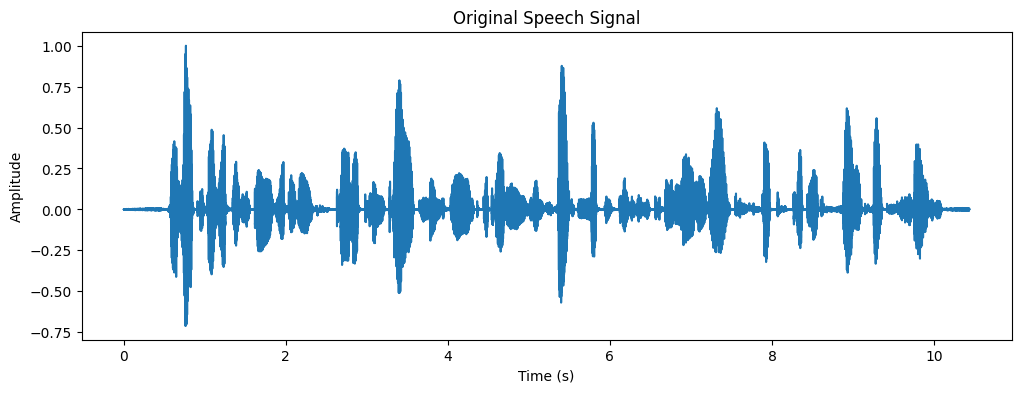

In [28]:
time = np.arange(0,len(audio)) / sample_rate
plt.figure(figsize=(12,4))
plt.plot(time,audio)
plt.title('Original Speech Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Inference

Used librosa to load the FLAC audio file. This gives the waveform (audio data) and the sample rate. Sample Rate tells how frequently the signal is measured over time. Next we are normalizing the audio to ensure its amplitude is between -1 and 1. Finally created a time array and plot the audio waveform.

Sampling the speech signal at Different Rates

In [30]:
sampling_rates = [8000,16000,44100]
resampled_signals = []

for rate in sampling_rates:
    num_samples = int(len(audio) * rate / sample_rate)
    resampled = resample(audio, num_samples)
    resampled_signals.append(resampled)

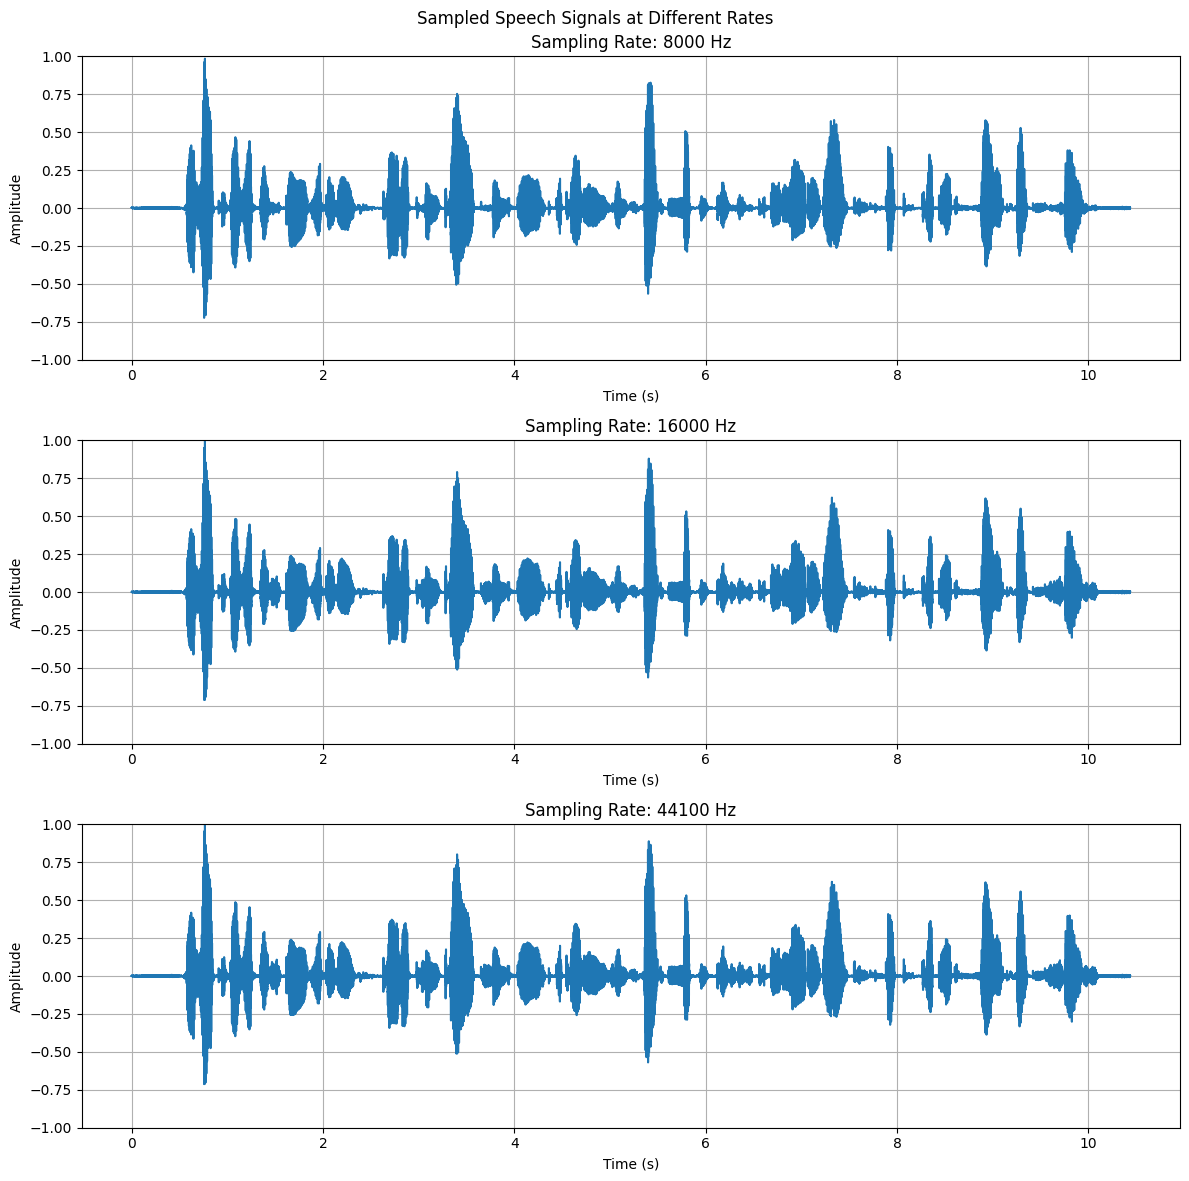

In [33]:
fig, axis = plt.subplots(3,1, figsize=(12,12))
fig.suptitle('Sampled Speech Signals at Different Rates')

for i, (rate,signal) in enumerate(zip(sampling_rates, resampled_signals)):
    time = np.arange(0,len(signal)) / rate
    axis[i].plot(time,signal)
    axis[i].set_title(f'Sampling Rate: {rate} Hz')
    axis[i].set_xlabel('Time (s)')
    axis[i].set_ylabel('Amplitude')
    axis[i].grid(True)  
    axis[i].set_ylim([-1, 1])
    
plt.tight_layout()
plt.show()

Inference

Sampling the speech signal in different rates. 8000Hz signal looks jagged and less detailed. The lower sampling rates captures fewer data points per second. 16000 Hz Sampling rates signal is smoother when compared to previous sample, it gave the better representation of the speech signal and commonly used in applications like speech recognition. 44100 Hz, the signal is very smooth and detailed, ideal for high quality audio applications like music recording.

Signal Reconstruction

In [34]:
def reconstruct_zero_order_hold(signal, original_rate, target_rate):
    time_original = np.arange(len(signal)) / original_rate
    time_target = np.arange(0, time_original[-1], 1/target_rate)
    interpolator = interp1d(time_original, signal, kind='nearest', bounds_error=False, fill_value='extrapolate')
    return interpolator(time_target)

def reconstruct_linear(signal, original_rate, target_rate):
    time_original = np.arange(len(signal)) / original_rate
    time_target = np.arange(0, time_original[-1], 1/target_rate)
    interpolator = interp1d(time_original, signal, kind='linear', bounds_error=False, fill_value='extrapolate')
    return interpolator(time_target)

reconstructed_signals_zoh = []
reconstructed_signals_linear = []

for resampled, rate in zip(resampled_signals, sampling_rates):
    reconstructed_zoh = reconstruct_zero_order_hold(resampled, rate, sample_rate)
    reconstructed_linear = reconstruct_linear(resampled, rate, sample_rate)
    reconstructed_signals_zoh.append(reconstructed_zoh)
    reconstructed_signals_linear.append(reconstructed_linear)

Inference

The original signal is resampled to a different lower sampling rates (8000Hz, 16000Hz etc).

The resampled signals are then reconstructed back to the original sampling rate using these methods. Since some information will be lost when we are sampling with different rates, we are doing this process. 

Calculating Mean Squared Error

In [35]:
def calculate_mse(original, reconstructed):
    min_length = min(len(original), len(reconstructed))
    return np.mean((original[:min_length] - reconstructed[:min_length]) ** 2)

mse_zoh = [calculate_mse(audio, rec) for rec in reconstructed_signals_zoh]
mse_linear = [calculate_mse(audio, rec) for rec in reconstructed_signals_linear]

print("Mean Squared Error (MSE) for Zero-Order Hold:")
for rate, mse in zip(sampling_rates, mse_zoh):
    print(f"Sampling Rate {rate} Hz: {mse:.6f}")

print("\nMean Squared Error (MSE) for Linear Interpolation:")
for rate, mse in zip(sampling_rates, mse_linear):
    print(f"Sampling Rate {rate} Hz: {mse:.6f}")

Mean Squared Error (MSE) for Zero-Order Hold:
Sampling Rate 8000 Hz: 0.000178
Sampling Rate 16000 Hz: 0.000052
Sampling Rate 44100 Hz: 0.000000

Mean Squared Error (MSE) for Linear Interpolation:
Sampling Rate 8000 Hz: 0.000062
Sampling Rate 16000 Hz: 0.000011
Sampling Rate 44100 Hz: 0.000000


### Inference

ZOH

8000Hz: Highest MSE, indicating the least accurate approximate of the original signal.

16000Hz: Lower MSE when compared to the previous, showing improved accuracy.

44100Hz: MSE is zero, indicating a perfect approximation of the original signal.

Linear Interpolation

8000Hz: Lower MSE than ZOH at the same sampling rate, indicating better accuracy.

16000Hz: Further reducted MSE, showing better accuracy.

44100Hz: Indicating a perfect approximation.

Higher Sampling Rates: Result in lower MSE, meaning the resampled signal is closer to the original.

Interpolation Methods: Linear interpolation was good when comparing to ZOH.


Conclusion

Increasing the sampling rate improves the quality of the reconstructed speech signal, making it closer to the original analog signal. Got the knowledge about sampling the signal into different rates and bringing back the signal to the original by reconstruction etc. And at last evaluated with MSE by comparing to both original and resampled for the comparison. Higher Sampling rates is suitable for capturing high quality audio.

# Question 2

Implementing the source filter model for a given speech signal and analyzing the impact of sampling and reconstruction on the quality of the speech signal.

# Generating a synthetic speech signal using the source filter model

Source Filter model has the ability to separate the source and filter components of speech.

Loading the data

In [39]:
audio_path = "./LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac"
waveform, fs = librosa.load(audio_path, sr=None)

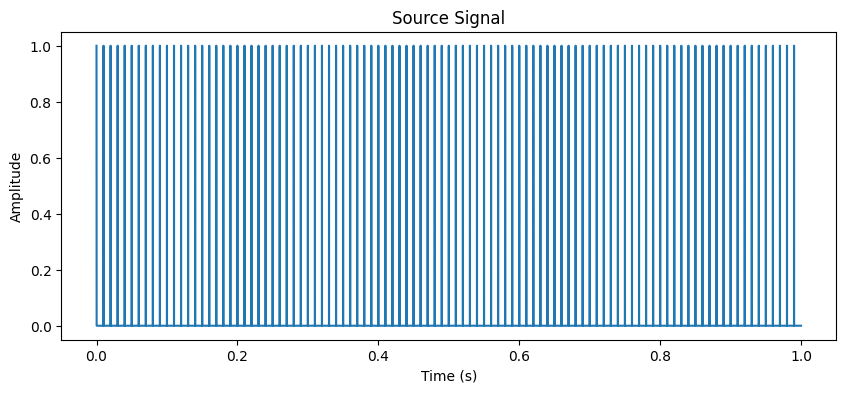

In [49]:
duration = 1.0  # seconds
f0 = 100  # fundamental frequency for voiced sound (Hz)

t = np.linspace(0, duration, int(fs * duration), endpoint=False)

glottal_pulse_train = np.zeros_like(t) # Voiced source signal 
glottal_pulse_train[::int(fs / f0)] = 1

white_noise = np.random.randn(len(t)) # Unvoiced source signal 

source_signal = glottal_pulse_train  

plt.figure(figsize=(10, 4))
plt.plot(t, source_signal)
plt.title('Source Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Inference

The vertical lines at regular intervals represent the impulses in the glottal pulse train, corresponding to the opening and closing of the vocal folds at a fundamental frequency of 100 hz.

Applying a Filter that Models the Vocal Tract

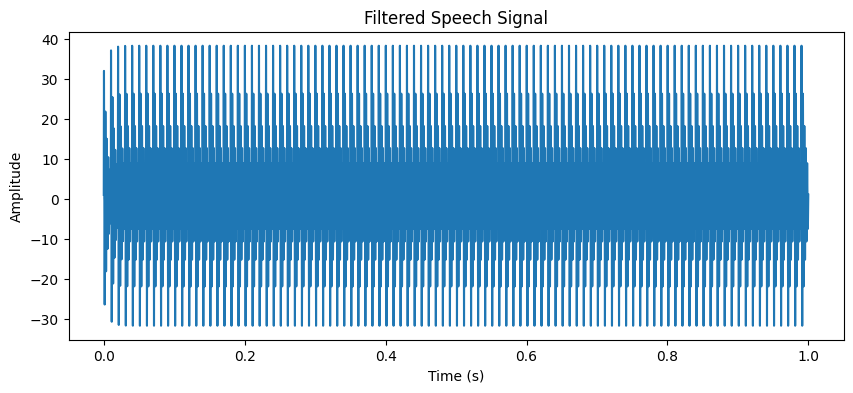

In [46]:
formant_freqs = [500, 1500, 2500] # formant frequencies (Hz) and bandwidths (Hz)
bandwidths = [50, 75, 100]

# Converting the formant frequencies and bandwidths to filter coefficients
def formant_filter(fs, formant_freqs, bandwidths):
    a = np.array([1.0])
    for f, bw in zip(formant_freqs, bandwidths):
        r = np.exp(-np.pi * bw / fs)
        theta = 2 * np.pi * f / fs
        p = np.array([1, -2 * r * np.cos(theta), r ** 2])
        a = np.convolve(a, p)
    return a

a = formant_filter(fs, formant_freqs, bandwidths)

filtered_signal = lfilter([1.0], a, source_signal)

plt.figure(figsize=(10, 4))
plt.plot(t, filtered_signal)
plt.title('Filtered Speech Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Inference

The plot visualizes the filtered speech signal, showing how the glottal pulse train has been shaped by the vocal tract filter. The variations in amplitude over time reflect the dynamic nature of speech, with the filter enhancing certain frequencies to produce a realistic speech sound.

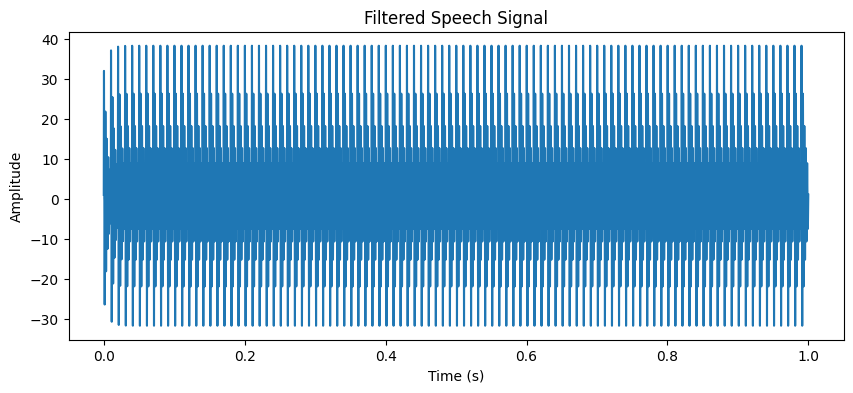

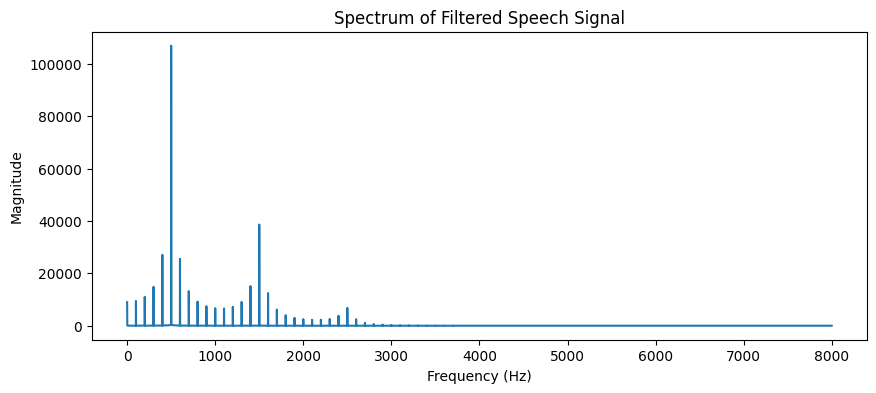

In [47]:
plt.figure(figsize=(10, 4))
plt.plot(t, filtered_signal)
plt.title('Filtered Speech Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

N = len(filtered_signal)
spectrum = np.abs(fft(filtered_signal))[:N // 2]
freqs = np.fft.fftfreq(N, 1 / fs)[:N // 2]

plt.figure(figsize=(10, 4))
plt.plot(freqs, spectrum)
plt.title('Spectrum of Filtered Speech Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

Inference

This visualizes the frequency components of the filtered speech signal, showing how the original glottal pulse has been shaped by the vocal tract filter.

Sampling the speech signal in different sampling rates (8 kHz, 16 kHz, 44.1 kHz)

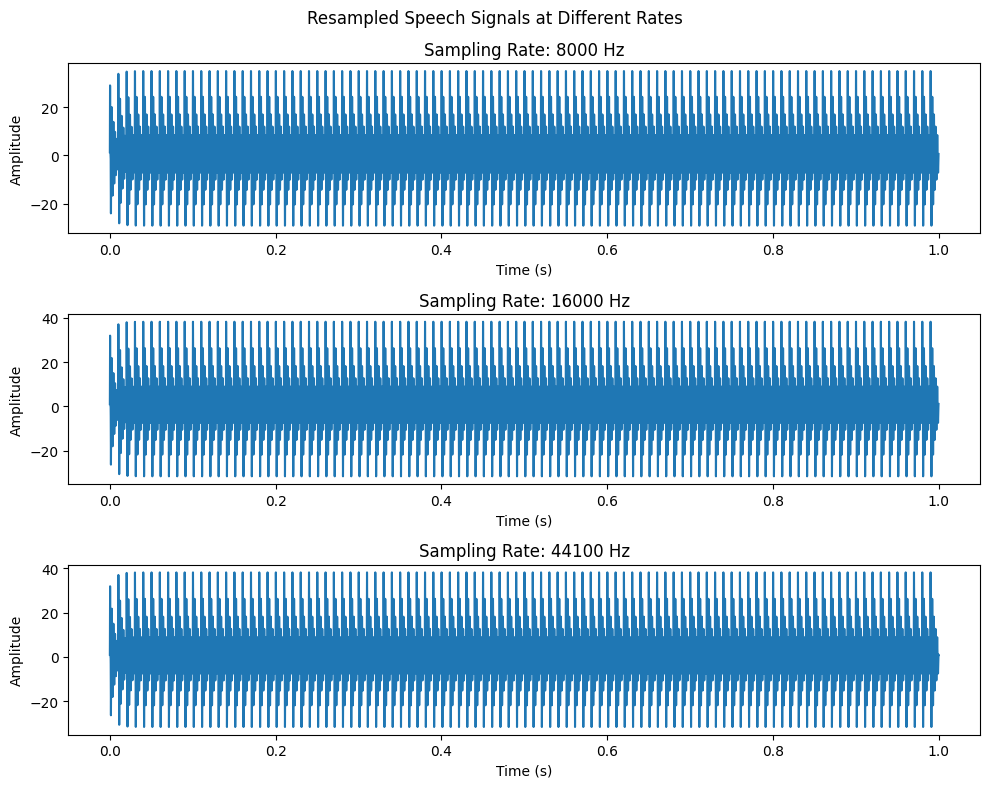

In [51]:
sampling_rates = [8000, 16000, 44100]
resampled_signals = []

for rate in sampling_rates:
    num_samples = int(len(filtered_signal) * rate / fs)
    resampled = resample(filtered_signal, num_samples)
    resampled_signals.append(resampled)

fig, axes = plt.subplots(len(sampling_rates), 1, figsize=(10, 8))
fig.suptitle('Resampled Speech Signals at Different Rates')

for i, (rate, signal) in enumerate(zip(sampling_rates, resampled_signals)):
    time_resampled = np.linspace(0, duration, len(signal), endpoint=False)
    axes[i].plot(time_resampled, signal)
    axes[i].set_title(f'Sampling Rate: {rate} Hz')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

Inference

This is the visualization of resampled speech signals at different rates. Higher sampling rates captures wide range of frequencies and fine details.

Signal Reconstruction

In [54]:
def reconstruct_zero_order_hold(signal, original_rate, target_rate):
    time_original = np.arange(len(signal)) / original_rate
    time_target = np.arange(0, time_original[-1], 1 / target_rate)
    interpolator = interp1d(time_original, signal, kind='nearest', bounds_error=False, fill_value='extrapolate')
    return interpolator(time_target)

def reconstruct_linear(signal, original_rate, target_rate):
    time_original = np.arange(len(signal)) / original_rate
    time_target = np.arange(0, time_original[-1], 1 / target_rate)
    interpolator = interp1d(time_original, signal, kind='linear', bounds_error=False, fill_value='extrapolate')
    return interpolator(time_target)

reconstructed_signals_zoh = []
reconstructed_signals_linear = []

for resampled, rate in zip(resampled_signals, sampling_rates):
    reconstructed_zoh = reconstruct_zero_order_hold(resampled, rate, fs)
    reconstructed_linear = reconstruct_linear(resampled, rate, fs)
    reconstructed_signals_zoh.append(reconstructed_zoh)
    reconstructed_signals_linear.append(reconstructed_linear)

Inference

Since some information will be lost after we performed sampling of the audio in different rates. So the resampled signals are reconstructed back to the original sampling rate.

Mean Squared Error

In [55]:
def calculate_mse(original, reconstructed):
    min_length = min(len(original), len(reconstructed))
    return np.mean((original[:min_length] - reconstructed[:min_length]) ** 2)

mse_zoh = [calculate_mse(filtered_signal, rec) for rec in reconstructed_signals_zoh]
mse_linear = [calculate_mse(filtered_signal, rec) for rec in reconstructed_signals_linear]

print("Mean Squared Error (MSE) for Zero-Order Hold:")
for rate, mse in zip(sampling_rates, mse_zoh):
    print(f"Sampling Rate {rate} Hz: {mse:.6f}")

print("\nMean Squared Error (MSE) for Linear Interpolation:")
for rate, mse in zip(sampling_rates, mse_linear):
    print(f"Sampling Rate {rate} Hz: {mse:.6f}")0

Mean Squared Error (MSE) for Zero-Order Hold:
Sampling Rate 8000 Hz: 5.113653
Sampling Rate 16000 Hz: 0.000000
Sampling Rate 44100 Hz: 0.131714

Mean Squared Error (MSE) for Linear Interpolation:
Sampling Rate 8000 Hz: 0.315718
Sampling Rate 16000 Hz: 0.000000
Sampling Rate 44100 Hz: 0.000326


Inference

When comparing to Zero Order Hold, the linear interpolation is good. For sampling rate of 16000 Hz MSE is too low, its a good sign, applicable for both the method. Rest all other mse values are higher especially for 8000HZ. 

16000 Hz is sufficient for this signal. For high quality audio a higher sampling rate combined with the linear interpolation may be a great choice to move on.

Conclusion

In both scenario loaded the speech data and performed preprocessing and did some visualizations and also the sampling of the audio with different sampling rates, to bring back the original performed reconstruction. After that calculated MSE for the comparison of the original audio signal and the reconstructed signal. In the second scenario created the source filter model, it is widely used in human speech production. It separates speech signals into two components a source (glottal signal) and a filter (vocal tract). In both the cases got the knowledge of analyzing speech signals.